Here I'll just grab a single point in the sky and look at what some possible light curves could look like. This could be handy if one wanted to test and refine some algorithms for deciding how good a light curve is.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
outDir ='LightCurve'
dbFile = 'enigma_1189_sqlite.db'
opsimdb = utils.connectOpsimDb(dbFile)
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
filters = ['u','g','r','i','z','y']
colors={'u':'cyan','g':'g','r':'y','i':'r','z':'m', 'y':'k'}

**Parameters to set**

In [4]:
# Set RA, Dec for a single point in the sky. in radians.
ra = np.radians(0.)
dec = np.radians(0.)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

In [5]:
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsimdb,
                                      outDir=outDir, resultsDb=resultsDb)

In [6]:
bg.runAll()

Querying database with no constraint.
Found 2469307 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundle.metricValues.data[0]['filter']

array(['u', 'i', 'i', ..., 'z', 'y', 'i'], 
      dtype='|S256')

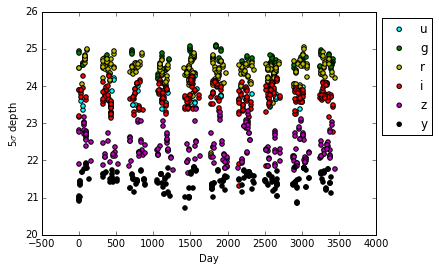

In [8]:
dayZero = bundle.metricValues.data[0]['expMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

In [9]:
print '%i Observations total at this point (All SNR levels)' % bundle.metricValues.data[0].size
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    print '%i Observations in %s' % (good[0].size, fname)

1173 Observations total at this point (All SNR levels)
75 Observations in u
112 Observations in g
272 Observations in r
259 Observations in i
223 Observations in z
232 Observations in y


In [12]:
data = bundle.metricValues.data[0]
peakTime = 15
transDuration = peakTime+30 # Days
peaks = {'uPeak':25.9, 'gPeak':23.6, 'rPeak':22.6, 'iPeak':22.7, 'zPeak':22.7,'yPeak':22.8}
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30.0, 
                                      transDuration=transDuration, peakTime=peakTime, 
                                      surveyDuration=10, **peaks)
lc = transMetric.lightCurve((data['expMJD']-dayZero) % transDuration, data['filter'])
snr = utils.m52snr(lc,data['fiveSigmaDepth'])
lc_err = 2.5*np.log10(1.+1./snr)

Fraction of LCs that meet criteria and plotted = 33/77


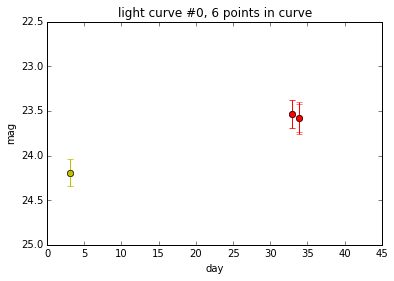

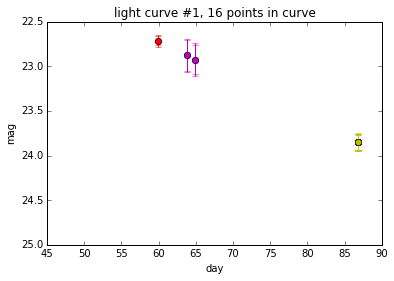

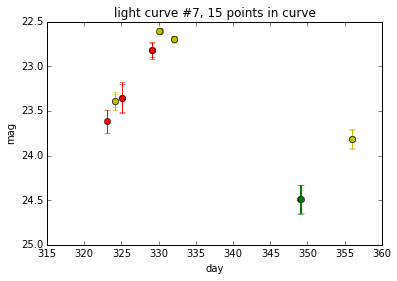

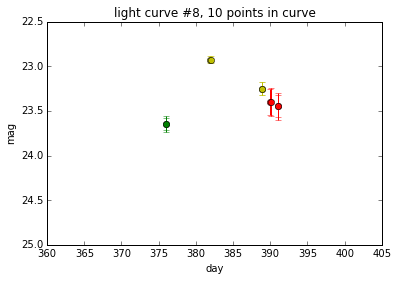

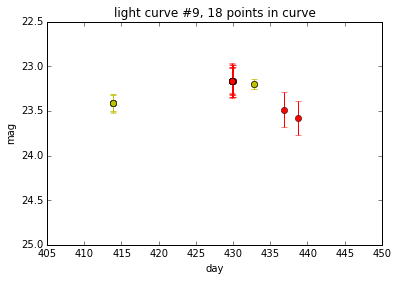

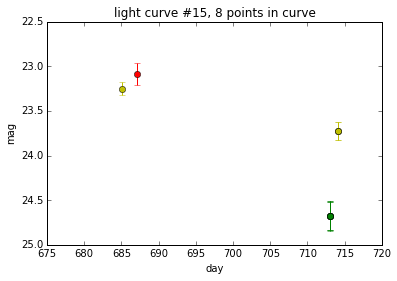

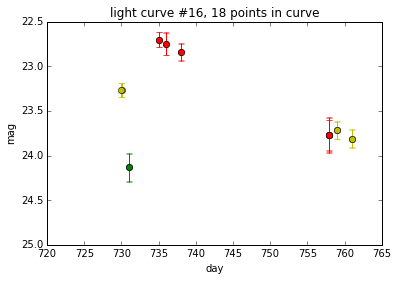

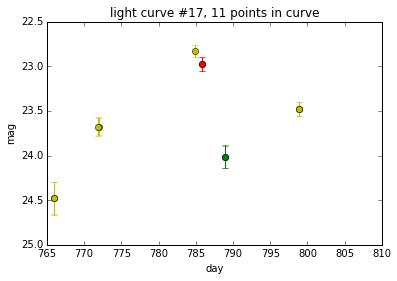

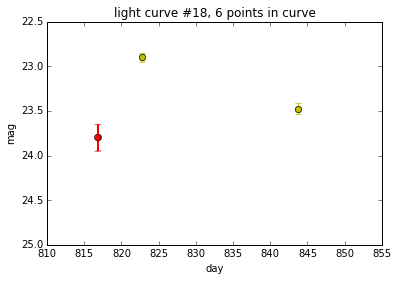

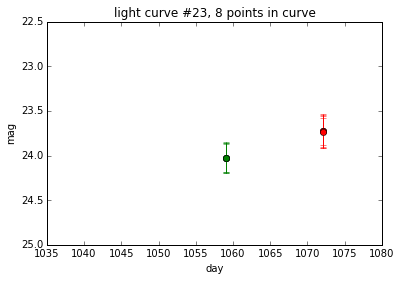

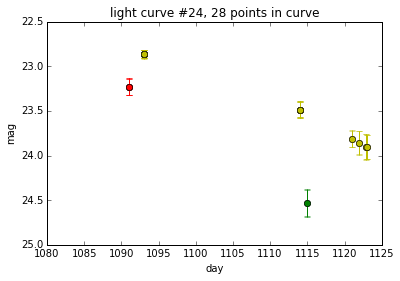

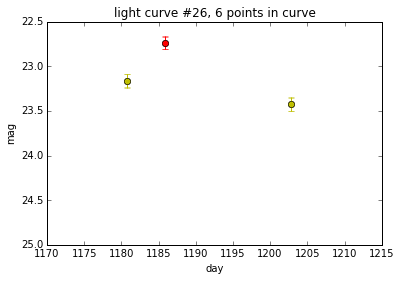

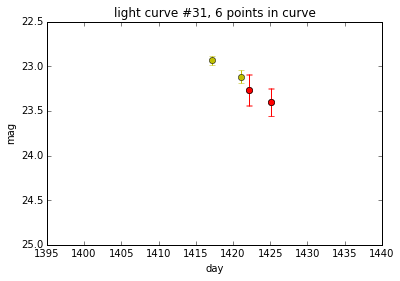

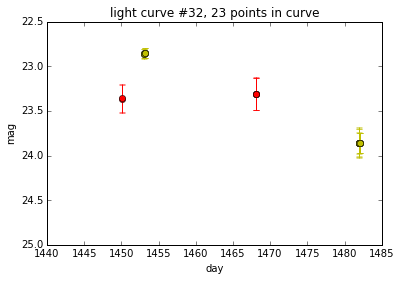

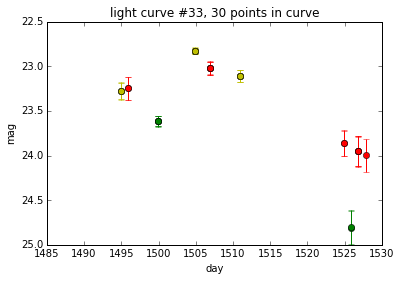

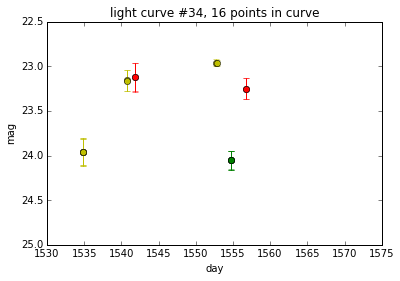

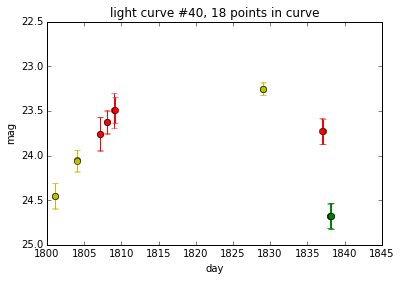

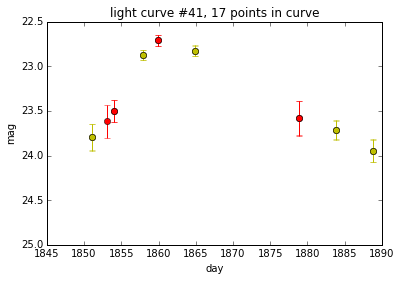

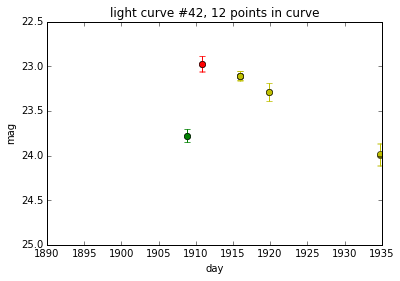

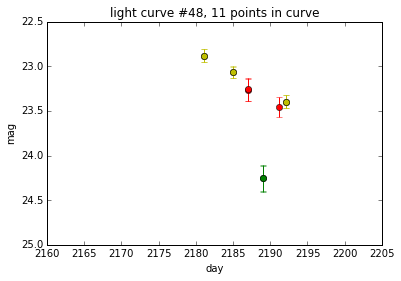

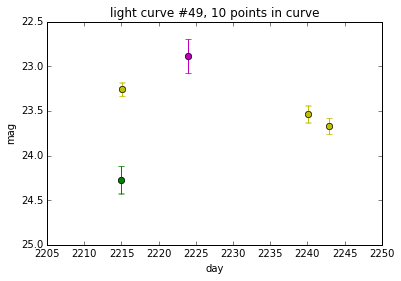

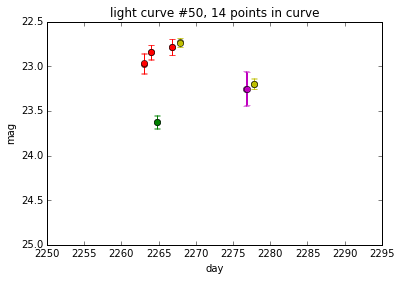

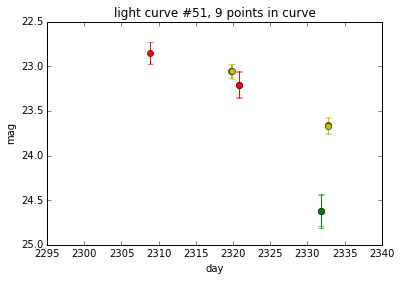

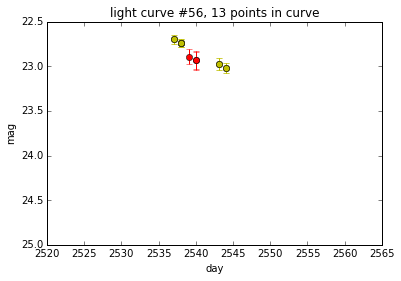

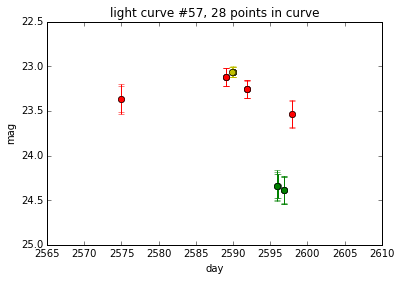

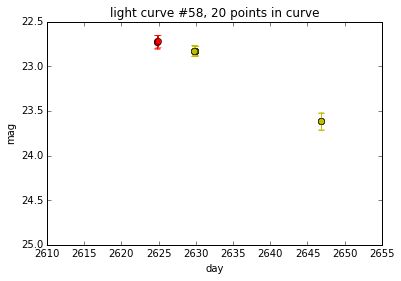

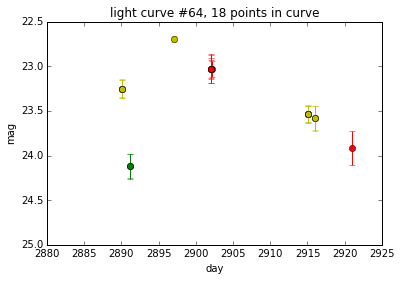

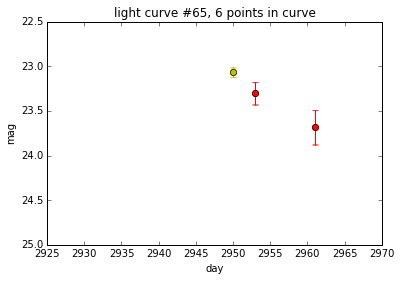

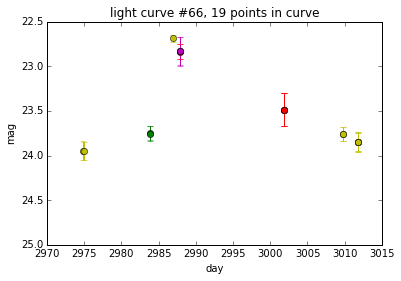

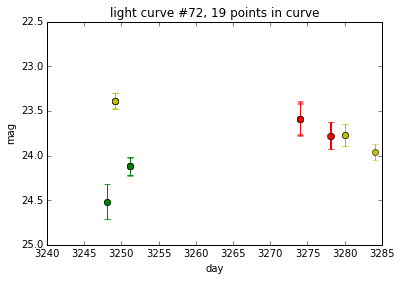

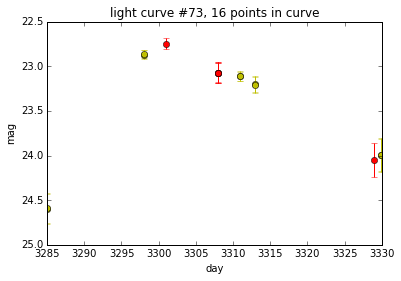

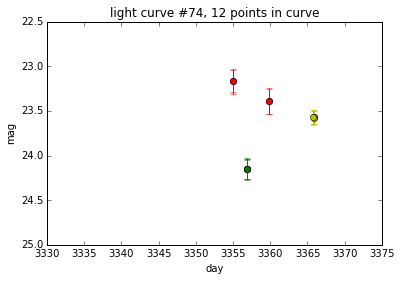

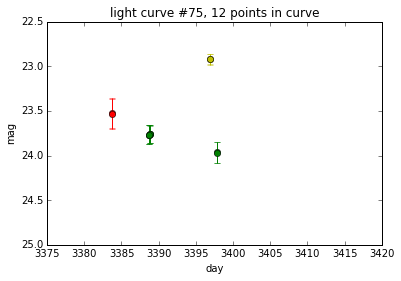

In [13]:
numOfLCs = np.ceil((data['expMJD'].max()-data['expMJD'].min())/transDuration)
plotCounter = 0
for lcn in np.arange(0,numOfLCs+1,1):
    good = np.where(( data['expMJD'] >= data['expMJD'].min()+transDuration*lcn)
                       & ( data['expMJD'] <= data['expMJD'].min()+transDuration*(1+lcn))
                       & (snr > snrLimit))
    if good[0].size >= nPtsLimit:
        plotCounter += 1
        plt.figure()
        # Counter
        numPoints = 0
        for filterName in filters:
            good = np.where((data['filter'] == filterName) & 
                            ( data['expMJD'] >= data['expMJD'].min()+transDuration*lcn)
                           & ( data['expMJD'] <= data['expMJD'].min()+transDuration*(1+lcn))
                           & (snr > snrLimit))
            plt.errorbar(data['expMJD'][good]-dayZero, lc[good], yerr=lc_err[good], 
                         c=colors[filterName], marker='o', linestyle='None')
            numPoints += good[0].size
        explodeDate=data['expMJD'].min()+transDuration*lcn
        plt.xlim([explodeDate-dayZero,explodeDate+transDuration-dayZero])
        plt.xlabel('day')
        plt.ylabel('mag')
        plt.title('light curve #%i, %i points in curve ' % (lcn, numPoints))
        plt.ylim([25., 22.5])
print 'Fraction of LCs that meet criteria and plotted = %i/%i' % (plotCounter, numOfLCs)